# QF 627 Programming and Computational Finance
## Problem-Sets for Exercise `7` | `Questions`

> Hi, Team. 👋

> The exercise questions ask you to solve three bigger questions. As with our previous exercise problem sets, while answering the questions you will be able to incorporate what you learned in class and consolidate your understanding.

> Enjoy!"🤞

### For standardization of your answers…

> Please execute the lines of code below before you start work on your answers.

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import talib
import matplotlib as mpl
import time
import datetime as dt
import re
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf


yf.pdr_override()

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.preprocessing import StandardScaler

> Let's set some print option.

In [73]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

## 👇 <font color = "purple"> Bigger Question 1. 

> Here's something that's familiar to you, with a few minor tweaks.

### Please create a predictive model for the weekly return of AMZN stock. You will use supervised learning for your predictive modelling.

> As you learned in class, to do this it is essential to know what factors are related to Amazon’s stock price, and to incorporate as much information as you can into the model.

> Among the three major factors (correlated assets, technical indicators, and fundamental analysis), you will use correlated assets and technical indicators as features here.

    Step 1. Use 75% of your data for the training of your algorithm, and 25% for the testing set.

    Step 2. For your feature engineering...
    
> Our operational definition of `outcome` (`Y`) is the weekly return of Amazon (AMZN). The number of trading days in a week is assumed to be five, and we compute the return using five trading days. 
<br>
    
* <font color = "green"> NOTE: The lagged five-day variables embed the time series component by using a time-delay approach, where the lagged variable is included as one of the predictor variables. This step translates the time series data into a supervised regression-based model framework.
<br>    
    
> For `input features` (`predictors`; `Xs`), we use (The variables used as predictors are as follows) ...

> `Correlated assets`

* lagged five-day returns of stocks (AAPL, MSFT, F);
* currency exchange rates (USD/JPY and GBP/USD);
* indices (S&P 500, Dow Jones, and VIX);
* lagged five-day, 15-day, 30-day, and 60-day returns of AMZN.

> `Technical indicators`

* 21-day, 63-day, and 252-day moving averages;
* 10-day, 30-day, and 200-day exponential moving averages.

    
    Step 3. For your algorithm of choices, please assess the model performance of the following algorithms: 

* Linear Regression
* Elastic Net
* LASSO
* Support Vector Machine
* K-Nearest Neighbor
* ARIMA
* Decision Tree
* Extra Trees 
* Random Forest
* Gradient Boosting Tree
* Adaptive Boosting
    
    
    Step 4. For this exercise, hyperparameter tuning won’t be requested. 
    
    Step 5. But make sure to compare the model performance of the above algorithms.

> The metric for assessing model performance will be mean squared error (`MSE`).
<br>

> Show which of the algorithms perform relatively better by a comparison visualization of performance, for both the training and testing sets learned in class. 

    Step 6. Using the model of your choice, please visualize the actual vs. predicted (estimated) data.

### Below are the lines of code that lead to an answer:

In [74]:
# Step 1 and 2: Data Preparation and feature engineering

stock_ticker = ["MSFT", "AAPL", "F", "AMZN"]
currency_ticker = ["DEXJPUS", "DEXUSUK"]
index_ticker = ["SP500", "DJIA", "VIXCLS"]
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2020, 12, 31)
stock_data = pdr.get_data_yahoo(stock_ticker, start = start_date, end = end_date)
currency_data = pdr.get_data_fred(currency_ticker,  start = start_date, end = end_date)
index_data = pdr.get_data_fred(index_ticker,  start = start_date, end = end_date)

# Because 5days lag period
return_period = 5

#Definition of outcome(Y) which is AMZN weekly return
Y =(np.log(stock_data.loc[ : , ("Adj Close", "AMZN")]).diff(return_period).shift(-return_period))
#Definition of prediction Y
Y.name =(Y.name[-1]+"_pred")

#Listing the input features(X)
#X1 = lagged 5 day returns of stocks
#X2 = lagged 5 day for currency pairs
#X3 = lagged 5 day for indices
#X4 = lagged 5-day, 15-day, 30-day, and 60-day returns of AMZN
#X5 = 21-day, 63-day, and 252-day moving averages; 10-day, 30-day, and 200-day exponential moving averages.
X1 =(np.log(stock_data.loc[ : , ("Adj Close", ("MSFT", "AAPL", "F"))]).diff(return_period))
X1.columns =(X1.columns.droplevel())
X2 =(np.log(currency_data).diff(return_period))
X3 = (np.log(index_data).diff(return_period))
X4 =(pd.concat([np.log(stock_data.loc[ : , ("Adj Close", "AMZN")])
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]],axis = 1).dropna())
X4.columns = ["AMZN_5DT", "AMZN_15DT", "AMZN_30DT", "AMZN_60DT"]
X5 = pd.concat([
    stock_data.loc[:, ("Adj Close", "AMZN")].rolling(window=21).mean(),
    stock_data.loc[:, ("Adj Close", "AMZN")].rolling(window=63).mean(),
    stock_data.loc[:, ("Adj Close", "AMZN")].rolling(window=252).mean(),
    stock_data.loc[:, ("Adj Close", "AMZN")].ewm(span=10).mean(),
    stock_data.loc[:, ("Adj Close", "AMZN")].ewm(span=30).mean(),
    stock_data.loc[:, ("Adj Close", "AMZN")].ewm(span=200).mean()], axis=1).dropna()
X5.columns = ['SMA_21', 'SMA_63', 'SMA_252', 'EMA_10', 'EMA_30', 'EMA_200']
#Combine all input features into a dataframe named X
X=(pd.concat([X1, X2, X3, X4, X5],axis = 1))
#Combine Y and X together into a dataframe
data =(pd.concat([Y, X],axis = 1).dropna().iloc[ : :return_period, :])
Y = data.loc[ : , Y.name]
X = data.loc[ : , X.columns]
#Split into 75% training set, 25% testing set
validation_size = 0.25 # this refers to testing set
train_size =int(len(X) * (1 - validation_size))
X_train, X_test =(X[0 :train_size], X[train_size:len(X)])
Y_train, Y_test =(Y[0 :train_size], Y[train_size:len(X)])

[*********************100%%**********************]  4 of 4 completed


In [75]:
# Step 3: Loading Algorithm 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf
# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

models = []
models.append(("LinearRegression", LinearRegression()))
models.append(("ElasticNet", ElasticNet()))
models.append(("LASSO", Lasso()))
models.append(("SupportVectorMachine", SVR()))
models.append(("KNN", KNeighborsRegressor()))
models.append(("DecisionTreeR", DecisionTreeRegressor()))
models.append(("ExtraTreesR", ExtraTreesRegressor()))
models.append(("RandomForestR", RandomForestRegressor()))
models.append(("GradientBoostR", GradientBoostingRegressor()))
models.append(("AdaBoostR", AdaBoostRegressor()))

In [76]:
#Step 4 and 5: Compare model performance for each algorithms (ARIMA separated out first)
# Initialization of Lists to store results
num_folds = 10
seed = 231018 #today's date
scoring = "neg_mean_squared_error"
names = []
kfold_results = [] # hyper-parametertuning
train_results = []
test_results = []

for name, model in models:
    names.append(name)
    kfold =(KFold(n_splits = num_folds,random_state = seed, shuffle = True))
    cv_results =( -1  * cross_val_score(model, X_train, Y_train,cv = kfold,scoring = scoring))
    kfold_results.append(cv_results)
  
    res = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result) 
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    # message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
    #                                  cv_results.std(), 
    #                                  train_result, 
    #                                  test_result)

In [77]:
##Step 5.1 : Adding ARIMA set-up to model performance comparison
X_train_ARIMA =(X_train.loc[ : ,['MSFT', 'AAPL', 'F', 'DEXJPUS', 'DEXUSUK', 'SP500', 'DJIA',
       'VIXCLS', 'AMZN_5DT', 'AMZN_15DT', 'AMZN_30DT', 'AMZN_60DT', 'SMA_21',
       'SMA_63', 'SMA_252', 'EMA_10', 'EMA_30', 'EMA_200']])

X_test_ARIMA =(X_test.loc[ : ,['MSFT', 'AAPL', 'F', 'DEXJPUS', 'DEXUSUK', 'SP500', 'DJIA',
       'VIXCLS', 'AMZN_5DT', 'AMZN_15DT', 'AMZN_30DT', 'AMZN_60DT', 'SMA_21',
       'SMA_63', 'SMA_252', 'EMA_10', 'EMA_30', 'EMA_200']])    

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)
modelARIMA =(stats.ARIMA(endog = Y_train,
                        exog = X_train_ARIMA,
                        order = [1, 0, 1]))
model_fit = modelARIMA.fit()
error_training_ARIMA =(mean_squared_error(Y_train,model_fit.fittedvalues))

predicted =(model_fit.predict(start = train_len - 1,
                                end = total_len - 1,
                                exog = X_test_ARIMA)[1: ])

error_testing_ARIMA =(mean_squared_error(Y_test,predicted))

test_results.append(error_testing_ARIMA)
train_results.append(error_training_ARIMA)
names.append("ARIMA")

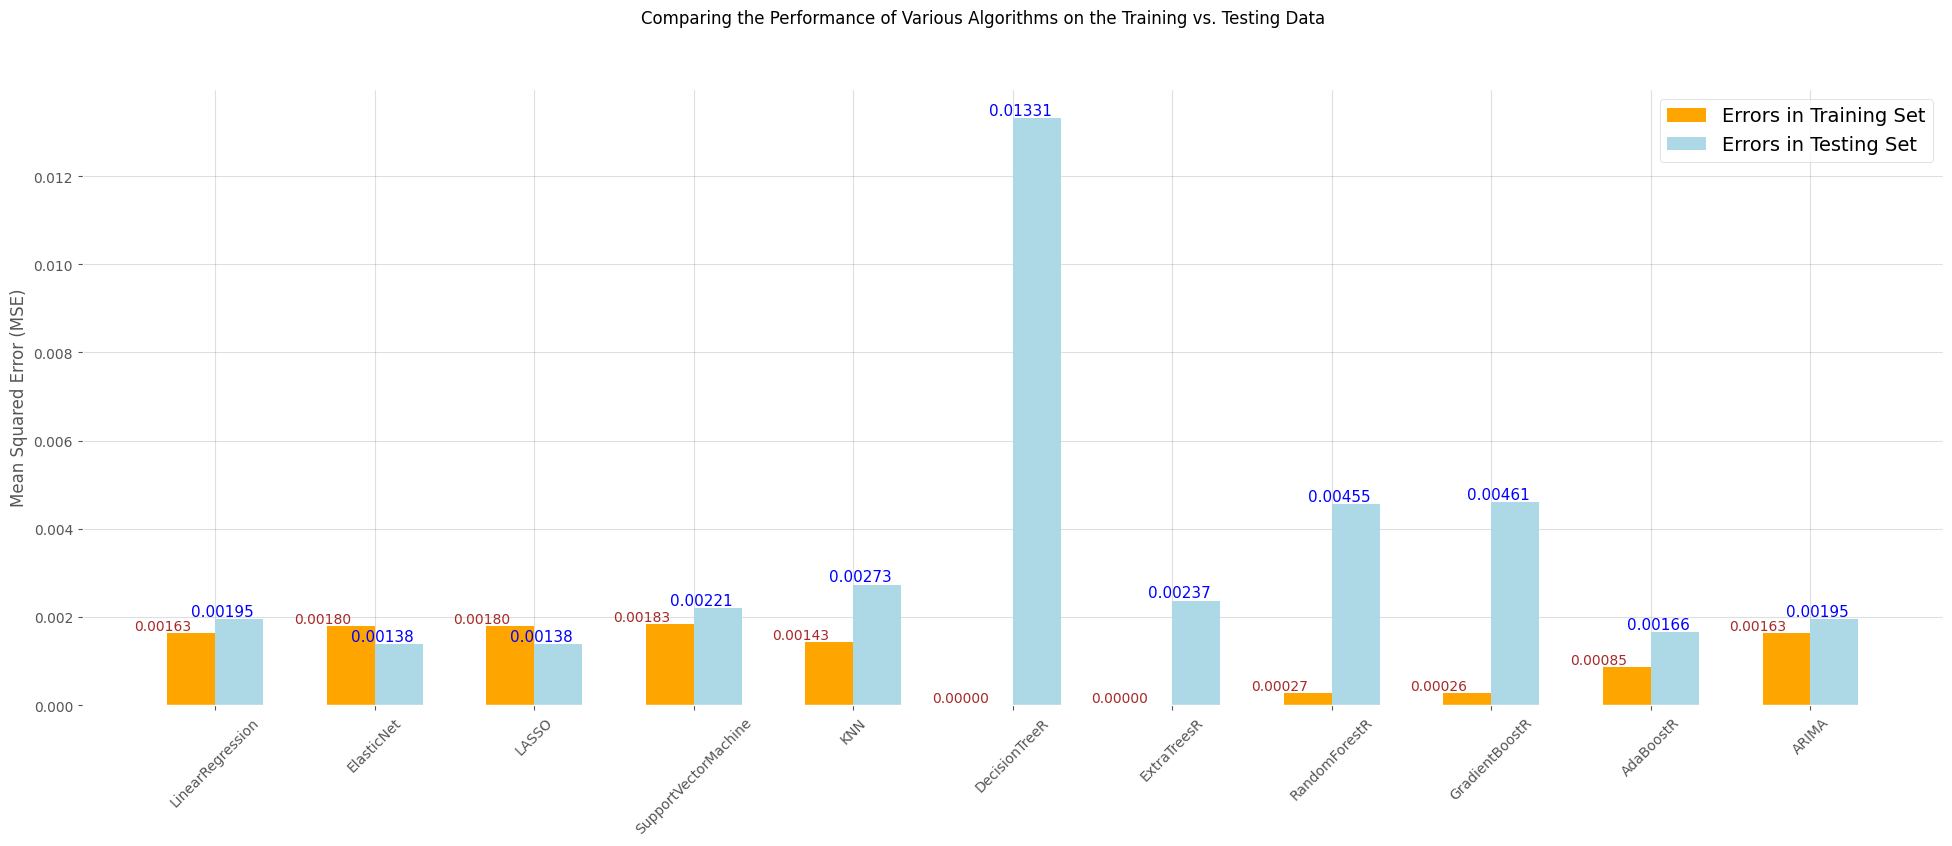

In [78]:
# Step 5.2 : Comparison visualization for all performances 
fig, ax = plt.subplots(figsize=(24, 8)) 
ind = np.arange(len(names))
width = 0.30
# Plot bars for training and testing results
train_bars = ax.bar(ind - width/2, train_results, width=width, label="Errors in Training Set", color='orange')
test_bars = ax.bar(ind + width/2, test_results, width=width, label="Errors in Testing Set", color='lightblue')

# Add a legend to the plot
ax.legend()

# Set x-axis ticks and labels
ax.set_xticks(ind)
ax.set_xticklabels(names, rotation=45)

# Label the y-axis
ax.set_ylabel("Mean Squared Error (MSE)")

# Set the title for the figure
fig.suptitle("Comparing the Performance of Various Algorithms on the Training vs. Testing Data")

# Add y-axis values on top of each bar
for bar, train_result, test_result in zip(train_bars, train_results, test_results):
    ax.text(bar.get_x() + bar.get_width() / 2, train_result, f'{train_result:.5f}', ha='right', va='bottom', fontsize=10,color='brown')
    ax.text(bar.get_x() + bar.get_width() / 2, test_result, f'{test_result:.5f}', ha='left', va='bottom', fontsize=11, color='blue')

# Display the plot
plt.show()

Observations: 
(1) Decision Tree / Extra Trees / Random Forest - very low MSE in training set and very high MSE in testing set which are all signs of overfitting. These models are very sensitive to small fluctuations in dataset, and would model outliers/noise in the training set, which means these models are learning all the datapoints and would not give good prediction.


(2) Linear Regression / Elastic Net / LASSO / SVM / ARIMA : these models yield similar MSE in training data & test data. They do not have extremely high MSE in testing data in comparison which makes them more ideal for prediction.

In [79]:
#Step 6: Choose a model to visualize the actual vs predicted. In this case, we chose ARIMA model.
# Assess for a better fit ARIMA model
def assess_ARIMA_model(arima_order):
    modelARIMA = stats.ARIMA(endog = Y_train, 
                             exog = X_train_ARIMA,
                             order = arima_order)
    
    model_fit = modelARIMA.fit()
    
    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)
    
    return error

def assess_models(p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order                    
                except:
                    continue
    print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
          )
    
# parameters to use for assessment

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
assess_models(p_values, d_values, q_values)

Best ARIMA(2, 0, 0) MSE = 0.0016182


In [80]:
#Based on the assessment above, ARIMA(2,0,0) is recommended so we label it as ARIMA_Tuned

ARIMA_Tuned =(stats.ARIMA(endog = Y_train,
                        exog = X_train_ARIMA,
                         order = [2,0,0]))

ARIMA_Fit_Tuned = ARIMA_Tuned.fit()
error_training_ARIMA_gridsearch =(mean_squared_error(Y_train,
                       ARIMA_Fit_Tuned.fittedvalues))

predicted_gridsearch =(ARIMA_Fit_Tuned.predict(start = train_len - 1,
                                end = total_len - 1,
                                exog = X_test_ARIMA)[1: ])

error_testing_ARIMA_gridsearch =(mean_squared_error(Y_test,
                                            predicted_gridsearch))

test_results.append(error_testing_ARIMA_gridsearch)
train_results.append(error_training_ARIMA_gridsearch)
names.append("ARIMA_Tuned")

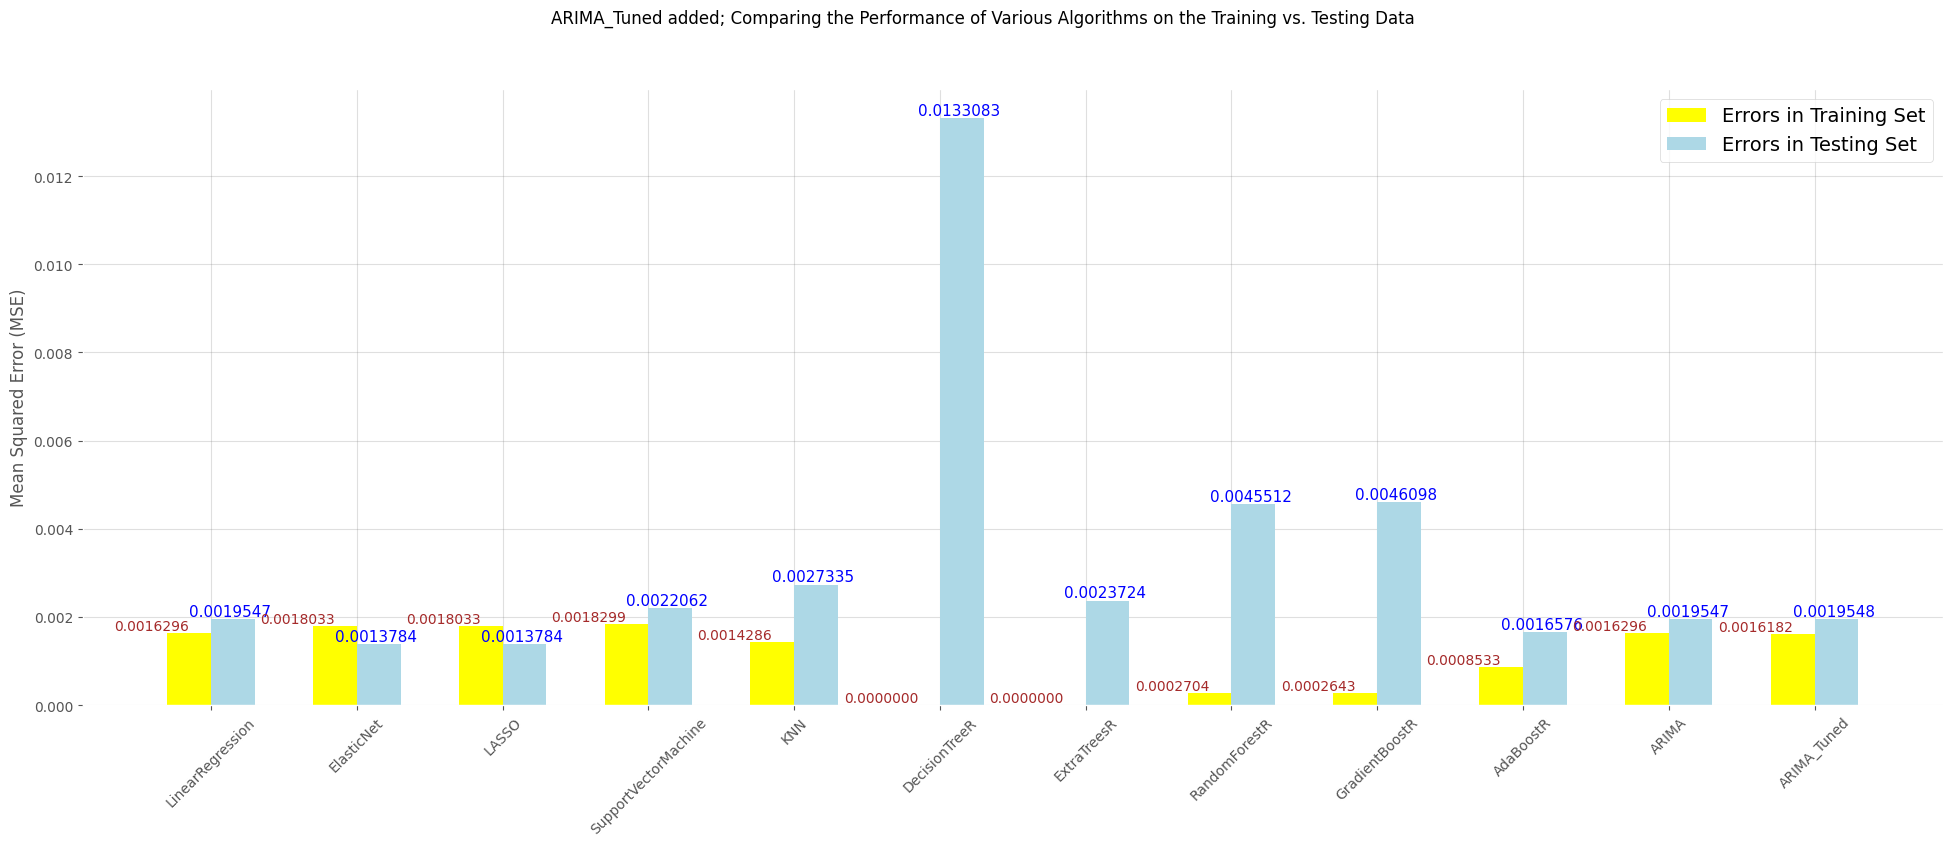

In [81]:
# Adding ARIMA_Tuned to the comparison visualization for all performances 
fig, ax = plt.subplots(figsize=(24, 8)) 
ind = np.arange(len(names))
width = 0.30
# Plot bars for training and testing results
train_bars = ax.bar(ind - width/2, train_results, width=width, label="Errors in Training Set", color='yellow')
test_bars = ax.bar(ind + width/2, test_results, width=width, label="Errors in Testing Set", color='lightblue')

# Add a legend to the plot
ax.legend()

# Set x-axis ticks and labels
ax.set_xticks(ind)
ax.set_xticklabels(names, rotation=45)  # You can adjust the rotation as needed

# Label the y-axis
ax.set_ylabel("Mean Squared Error (MSE)")

# Set the title for the figure
fig.suptitle("ARIMA_Tuned added; Comparing the Performance of Various Algorithms on the Training vs. Testing Data")

# Add y-axis values on top of each bar
for bar, train_result, test_result in zip(train_bars, train_results, test_results):
    ax.text(bar.get_x() + bar.get_width() / 2, train_result, f'{train_result:.7f}', ha='right', va='bottom', fontsize=10,color='brown')
    ax.text(bar.get_x() + bar.get_width() / 2, test_result, f'{test_result:.7f}', ha='left', va='bottom', fontsize=11, color='blue')

# Display the plot
plt.show()

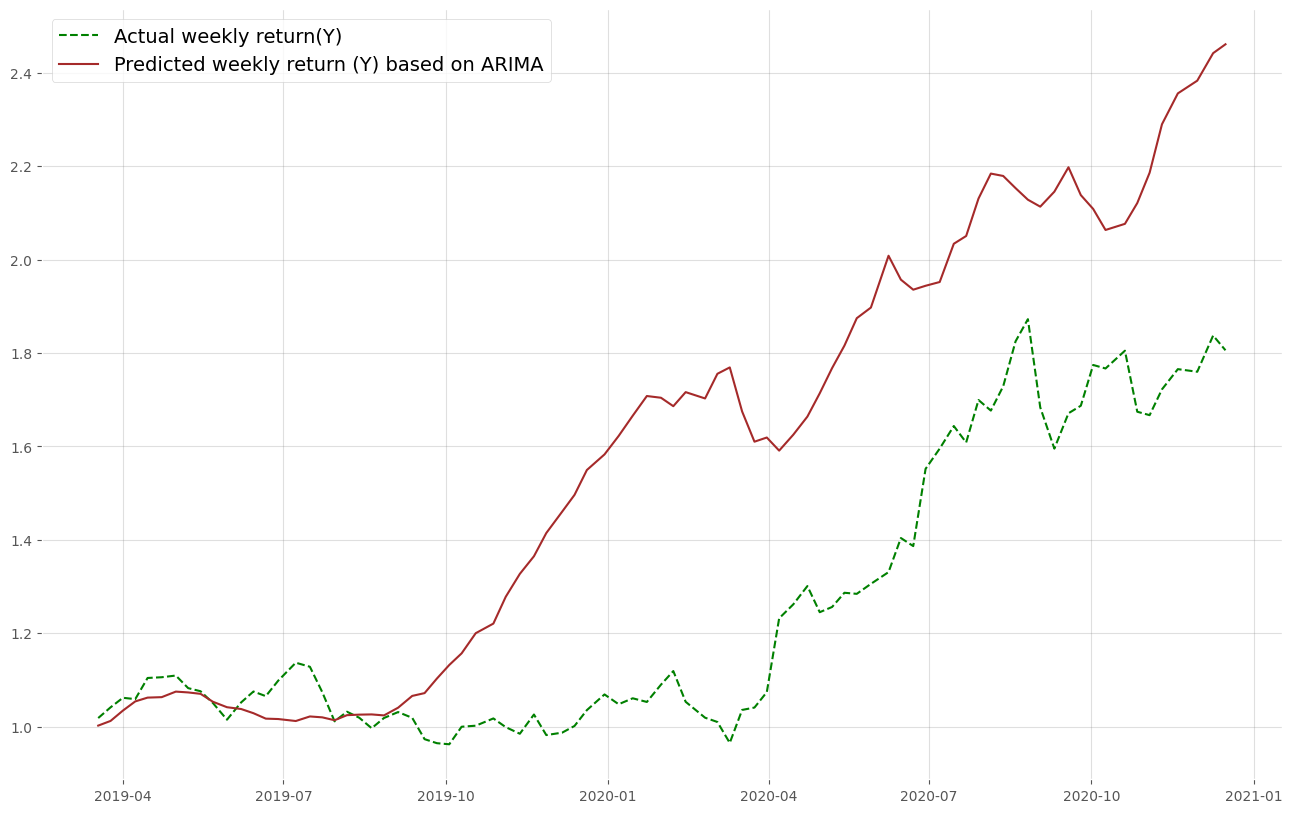

In [82]:
ARIMA_Original =model_fit.predict(start = train_len - 1,
                                    end = total_len - 1,
                                    exog = X_test_ARIMA)[1:]

plt.figure(figsize = (16, 10)
           )

ARIMA_Original.index = Y_test.index

plt.plot(np.exp(Y_test).cumprod(), "g--", label = "Actual weekly return(Y)")

plt.plot(np.exp(ARIMA_Original).cumprod(), "brown", label = "Predicted weekly return (Y) based on ARIMA")

plt.legend()
plt.show()

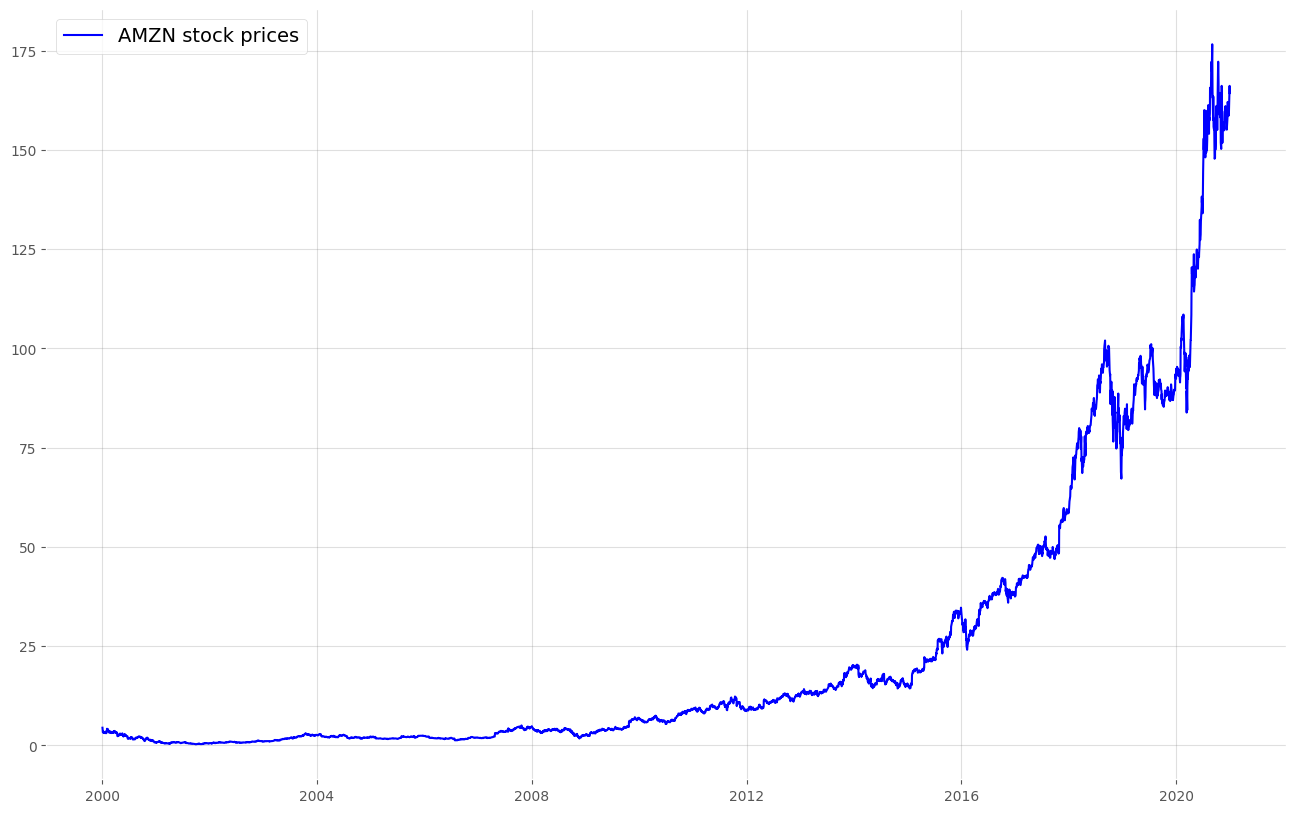

In [83]:
plt.figure(figsize = (16, 10))
plt.plot(stock_data.index, stock_data.loc[ : , ("Adj Close", "AMZN")] , "b", label = "AMZN stock prices")
plt.legend()
plt.show()

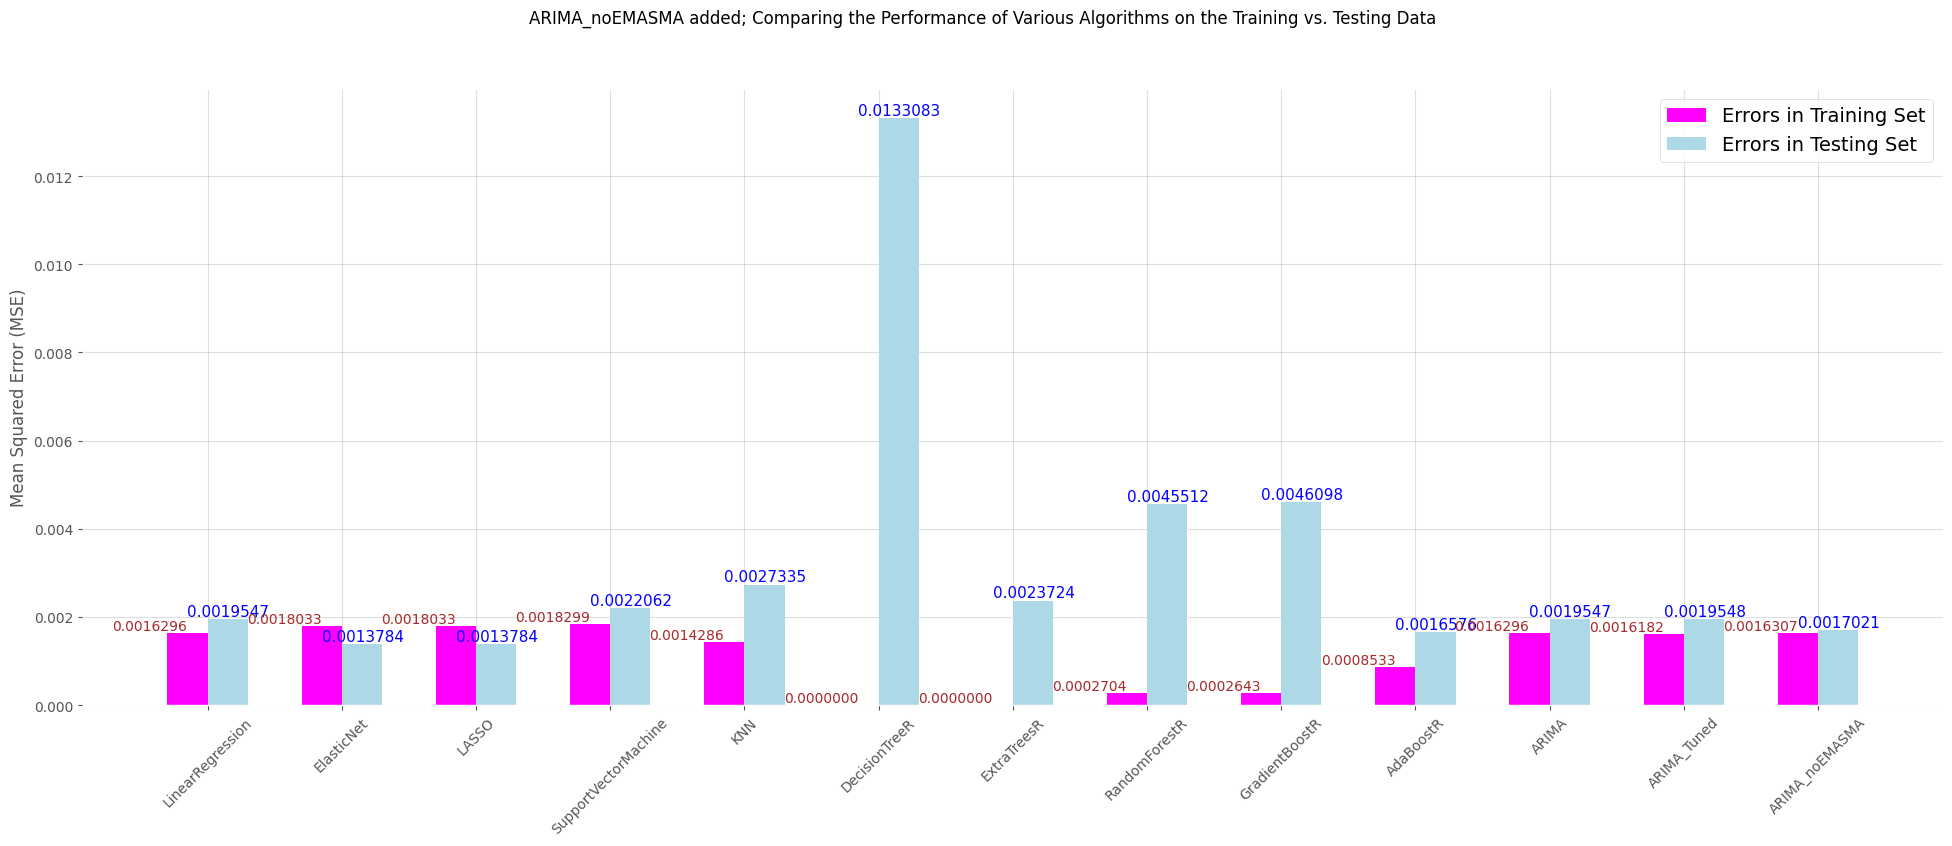

In [84]:
##Removing SMA & EMA from ARIMA
#ARIMA set-up to model performance comparison
X_train_ARIMA_noEMASMA =(X_train.loc[ : ,['MSFT', 'AAPL', 'F', 'DEXJPUS', 'DEXUSUK', 'SP500', 'DJIA',
       'VIXCLS', 'AMZN_5DT', 'AMZN_15DT', 'AMZN_30DT', 'AMZN_60DT']])

X_test_ARIMA_noEMASMA =(X_test.loc[ : ,['MSFT', 'AAPL', 'F', 'DEXJPUS', 'DEXUSUK', 'SP500', 'DJIA',
       'VIXCLS', 'AMZN_5DT', 'AMZN_15DT', 'AMZN_30DT', 'AMZN_60DT']])    

train_len = len(X_train_ARIMA_noEMASMA)
test_len = len(X_test_ARIMA_noEMASMA)
total_len = len(X)
modelARIMA_noEMASMA =(stats.ARIMA(endog = Y_train,
                        exog = X_train_ARIMA_noEMASMA,
                        order = [2, 0, 0]))
model_fit_noEMASMA = modelARIMA_noEMASMA.fit()
error_training_ARIMA_noEMASMA =(mean_squared_error(Y_train,model_fit_noEMASMA.fittedvalues))

predictedARIMA_noEMASMA =(model_fit_noEMASMA.predict(start = train_len - 1,
                                end = total_len - 1,
                                exog = X_test_ARIMA_noEMASMA)[1: ])

error_testing_ARIMA =(mean_squared_error(Y_test,predictedARIMA_noEMASMA))

test_results.append(error_testing_ARIMA)
train_results.append(error_training_ARIMA_noEMASMA)
names.append("ARIMA_noEMASMA")

# Adding ARIMA_noSMAEMA to the comparison visualization for all performances 
fig, ax = plt.subplots(figsize=(24, 8)) 
ind = np.arange(len(names))
width = 0.30
# Plot bars for training and testing results
train_bars = ax.bar(ind - width/2, train_results, width=width, label="Errors in Training Set", color='Magenta')
test_bars = ax.bar(ind + width/2, test_results, width=width, label="Errors in Testing Set", color='lightblue')

# Add a legend to the plot
ax.legend()

# Set x-axis ticks and labels
ax.set_xticks(ind)
ax.set_xticklabels(names, rotation=45)  # You can adjust the rotation as needed

# Label the y-axis
ax.set_ylabel("Mean Squared Error (MSE)")

# Set the title for the figure
fig.suptitle("ARIMA_noEMASMA added; Comparing the Performance of Various Algorithms on the Training vs. Testing Data")

# Add y-axis values on top of each bar
for bar, train_result, test_result in zip(train_bars, train_results, test_results):
    ax.text(bar.get_x() + bar.get_width() / 2, train_result, f'{train_result:.7f}', ha='right', va='bottom', fontsize=10,color='brown')
    ax.text(bar.get_x() + bar.get_width() / 2, test_result, f'{test_result:.7f}', ha='left', va='bottom', fontsize=11, color='blue')

# Display the plot
plt.show()

### <font color = red> Answer 1 is presented in the cell below: </font>

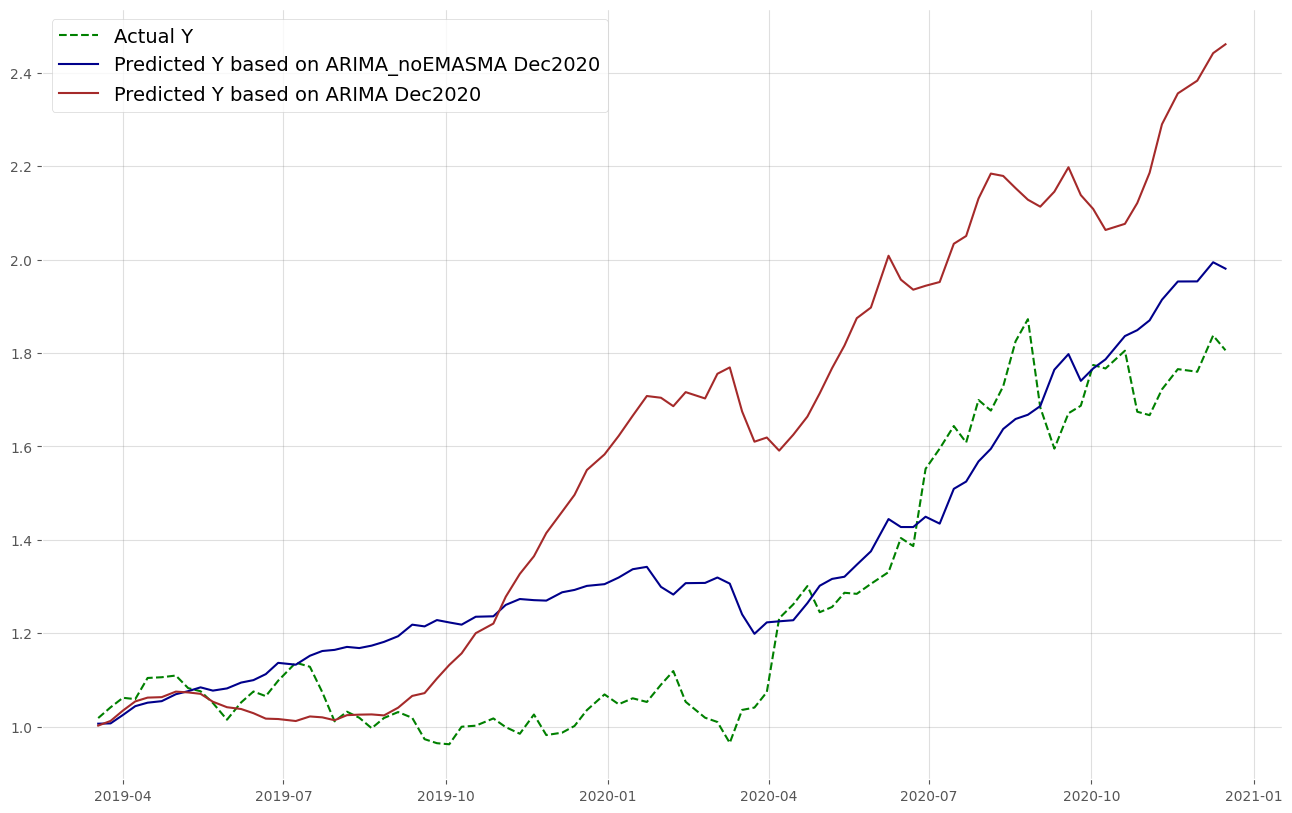

In [85]:
# Visualize both ARIMA models against actual Y
predictedARIMA_noEMASMA =(model_fit_noEMASMA.predict(start = train_len - 1,
                                end = total_len - 1,
                                exog = X_test_ARIMA_noEMASMA)[1: ])

plt.figure(figsize = (16, 10))
predictedARIMA_noEMASMA.index = Y_test.index
plt.plot(np.exp(Y_test).cumprod(), "g--", label = "Actual Y")
plt.plot(np.exp(predictedARIMA_noEMASMA).cumprod(), "darkblue", label = "Predicted Y based on ARIMA_noEMASMA Dec2020")
plt.plot(np.exp(ARIMA_Original).cumprod(), "brown", label = "Predicted Y based on ARIMA Dec2020")

plt.legend()
plt.show()

Observations: The blue-line prediction model which has no EMA&SMA as inputs ended up with a lower forecast outlook compared to the brown-line. By just looking at these graphs, the direct conclusion would be that the brown-line model produces a closer prediction to actual.

## <font color = blue> 👉 Questions 2 to 5 ask you to build, execute, and backtest a mean-reversion strategy, using `Relative Strength Index` (`RSI`). </font>

#### The Relative Strength Index (RSI) is an indicator that uses the closing prices of an asset to identify oversold and overbought conditions. 

> Most commonly, RSI is calculated using a 14-day period, and measured on a scale from zero to 100. (It is an oscillator.)

> Traders usually buy an asset when it is oversold (when its RSI is below 30) and sell when it is overbought (when its RSI is above 70). 

> More extreme overbought and oversold levels, such as 80 and 20, are used less frequently, and imply stronger momentum.

#### You are asked to build a trading strategy with the following set of rules.

### <font color = green> NOTE: Apple (`AAPL`) as our security of interest. The `investment horizon` will be three years between 2015 and 2017; your `capital` is USD 100,000; and there is a USD 5 flat `commission fee` per trade.

- You can go long and short.
<br>

- To calculate RSI, use 14 periods (trading days).
<br>

- Enter a long position if RSI crosses the lower threshold (standard value of 30), moving upwards. Exit the position when RSI becomes higher than the middle level (value of 50).
<br>

- Enter a short position if RSI crosses the upper threshold (standard value of 70), moving downwards. Exit the position when RSI becomes less than 50.
<br>

- Only one position can be open at a time.

### <font color = green> NOTE: The RSI is defined as follows:
    
### Calculating the RSI first requires the RS which requires an average value of n-many previous trading days. 
<br>
    
- As discussed, a value of 14 days is common for the RSI calculation. 
<br>
    
- The first RS value requires the price from all 14 of the first trading days. Often, this is a source of confusion with the RSI given successive values only require the most recent. 
   
    
    Step 1. For 14 periods, calculate the difference in price from the current period and the previous period
    
    Step 2. For each period, record each positive change in price as a gain and each negative change as a loss
    
    Step 3. On the 14th period, calculate the arithmetic mean of the gains and losses for the entire 14 day period (e.g. gains / 14 & losses / 14)
    
    Step 4. Use these values to calculate the RS
    
### <center> $ RS = \frac{AverageGain}{AverageLoss} $
    
    Step 5. Use the RS value to calculate the RSI
    
    Step 6. For each proceeding period, use only the previous RSI value to calculate the next average value 
    by multiplying by our lookback period – 1 (e.g., 13 for a lookback of 14).
    
    Step 7. Add the value obtained in Step 6 to the current day’s value (run this for both the gains and losses)
    
### <center> $ RSI = 100 - \frac{100}{1 + RS} $

### Visualize your buy and sell positions.

### Below are the lines of code that lead to an answer:

In [21]:
# Import data

start_date = dt.datetime(2015, 1, 1)
end_date = dt.datetime(2017, 12, 31)
AAPL = pdr.get_data_yahoo("AAPL", start = start_date, end = end_date)

# Calculate RSI

AAPL["diff"] = AAPL["Adj Close"].diff()

AAPL["gain"] = np.where(AAPL["diff"] > 0 ,AAPL["diff"], 0)
AAPL["loss"] = np.where(AAPL["diff"] < 0 ,-AAPL["diff"], 0)
AAPL["gain_av"] = AAPL["gain"].rolling(window = 14).mean()
AAPL["loss_av"] = AAPL["loss"].rolling(window = 14).mean()

AAPL["RS"] = AAPL["gain_av"]/AAPL["loss_av"]

AAPL["RSI"] = 100 - (100/(1+ AAPL["RS"]))
AAPL["RSI"]

[*********************100%%**********************]  1 of 1 completed


Date
2015-01-02          NaN
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
                ...    
2017-12-22    70.084950
2017-12-26    52.695577
2017-12-27    54.774665
2017-12-28    55.231924
2017-12-29    49.624084
Name: RSI, Length: 755, dtype: float64

In [22]:
AAPL[["RSI"]]

,RSI
Date,
2015-01-02,NaN
2015-01-05,NaN
2015-01-06,NaN
2015-01-07,NaN
2015-01-08,NaN
...,...
2017-12-22,70.084950
2017-12-26,52.695577
2017-12-27,54.774665


In [23]:
AAPL["position"] = np.nan

long  = (AAPL["RSI"].shift(1) < 30) & (AAPL["RSI"] >= 30) & (AAPL["position"].shift(1) !=-1)
short = (AAPL["RSI"].shift(1) > 70) & (AAPL["RSI"] <= 70) & (AAPL["position"].shift(1) !=-1)
exit  = ((AAPL['RSI'].shift(1) > 50) & (AAPL['RSI'] <= 50)) | ((AAPL['RSI'].shift(1) < 50) & (AAPL['RSI'] >= 50))

AAPL["position"] = np.where(long,1,AAPL["position"])
AAPL["position"] = np.where(short,-1,AAPL["position"])
AAPL["position"] = np.where(exit,0,AAPL["position"])

AAPL["position"].ffill(inplace = True)
AAPL['position'] = AAPL['position'].fillna(0)

In [24]:
AAPL["trading_signal"] = AAPL["position"].diff()

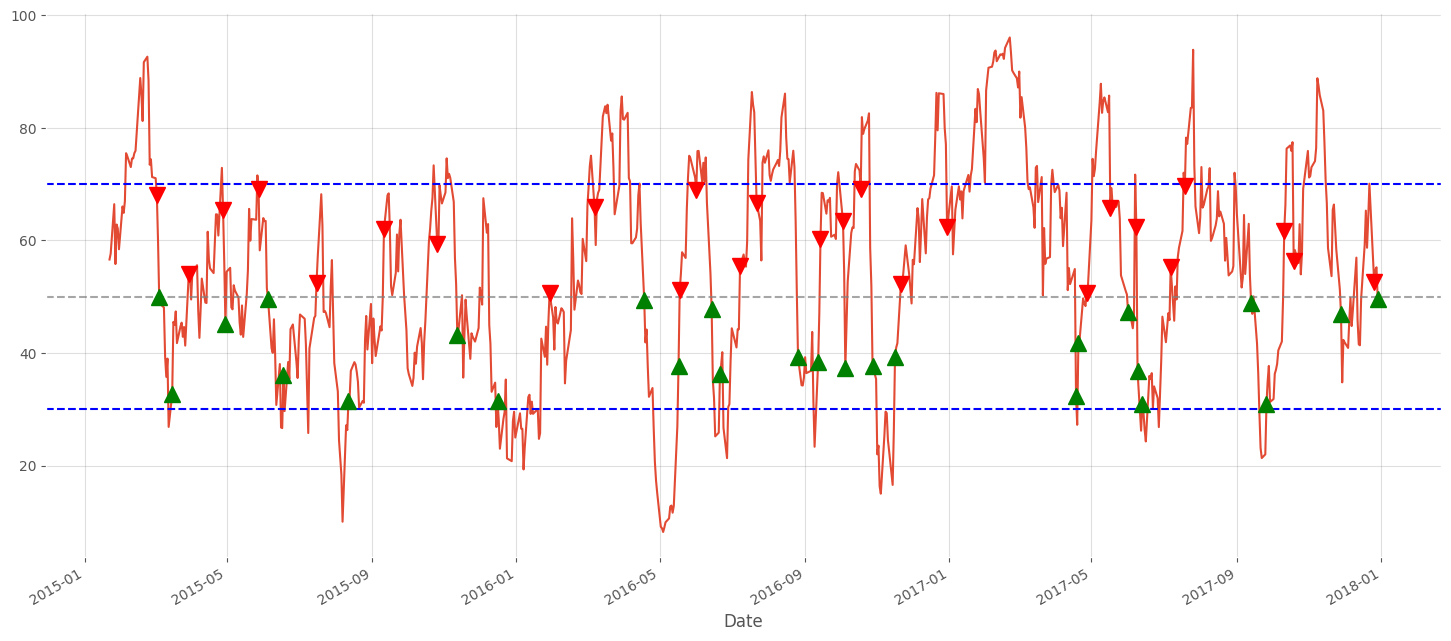

In [25]:
AAPL["RSI"].plot(figsize = [18,8])
plt.axhline(y=70, color = "blue", ls = "--")
plt.axhline(y=30, color = "blue", ls = "--")
plt.axhline(y=50, color = "grey", ls = "--", alpha = 0.7)


plt.plot(AAPL.loc[AAPL.trading_signal == 1.0].index,
          AAPL.RSI[AAPL.trading_signal == 1.0],
          "^",
          color = "green",
          markersize = 12)

plt.plot(AAPL.loc[AAPL.trading_signal == -1.0].index,
          AAPL.RSI[AAPL.trading_signal == -1.0],
          "v",
          color = "red",
          markersize = 12)

In [26]:
AAPL["trading_signal"].value_counts()

trading_signal
 0.0    702
-1.0     26
 1.0     26
Name: count, dtype: int64

In [27]:
AAPL[["RSI","trading_signal","position"]][:50]

,RSI,trading_signal,position
Date,,,
2015-01-02,NaN,NaN,0.0
2015-01-05,NaN,0.0,0.0
2015-01-06,NaN,0.0,0.0
2015-01-07,NaN,0.0,0.0
2015-01-08,NaN,0.0,0.0
2015-01-09,NaN,0.0,0.0
2015-01-12,NaN,0.0,0.0
2015-01-13,NaN,0.0,0.0
2015-01-14,NaN,0.0,0.0


### <font color = red> Answer 2 is presented in the cell below: </font>

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot with two subplots (2 rows, 1 column)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.09)

# Add the stock price chart in the top subplot
fig.add_trace(go.Scatter(x=AAPL.index, y=AAPL['Adj Close'], mode='lines', name='AAPL Close Price', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=AAPL[AAPL['trading_signal'] == 1].index, y=AAPL[AAPL['trading_signal'] == 1]['Adj Close'], mode='markers', marker=dict(color='green', symbol='triangle-up', size=9), name='Buy Position'), row=1, col=1)
fig.add_trace(go.Scatter(x=AAPL[AAPL['trading_signal'] == -1].index, y=AAPL[AAPL['trading_signal'] == -1]['Adj Close'], mode='markers', marker=dict(color='red', symbol='triangle-down', size=9), name='Sell Position'), row=1, col=1)

# Add the RSI chart in the bottom subplot
fig.add_trace(go.Scatter(x=AAPL.index, y=AAPL['RSI'], mode='lines', name='RSI', line=dict(color='brown')), row=2, col=1)
fig.add_hline(y=70, line_dash='dash', line_color='red', name='Overbought (70)', row=2, col=1)
fig.add_hline(y=30, line_dash='dash', line_color='green', name='Oversold (30)', row=2, col=1)
fig.add_hline(y=50, line_dash='dash', line_color='grey', name='Exit (50)', row=2, col=1)
fig.add_trace(go.Scatter(x=AAPL[AAPL['trading_signal'] == 1].index, y=AAPL[AAPL['trading_signal'] == 1]['RSI'], mode='markers', marker=dict(color='green', symbol='triangle-up', size=9), name='Buy Position'), row=2, col=1)
fig.add_trace(go.Scatter(x=AAPL[AAPL['trading_signal'] == -1].index, y=AAPL[AAPL['trading_signal'] == -1]['RSI'], mode='markers', marker=dict(color='red', symbol='triangle-down', size=9), name='Sell Position'), row=2, col=1)

# Update layout and axis labels
fig.update_layout(title_text='AAPL RSI and Buy/Sell Positions', height=900, width=1600)
fig.update_xaxes(title_text='Date', row=2, col=1)
fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_yaxes(title_text='RSI', row=2, col=1)

# Show the plot
fig.show()

### <font color = blue> 👉 Question 3</font>. How much in cumulative returns could you have had as a result of the RSI strategy?

### Below are the lines of code that lead to an answer:

In [29]:
initial_capital = 1e5
AAPL['log_returns'] = np.log(AAPL['Adj Close'] / AAPL['Adj Close'].shift(1))
AAPL['capital'] = initial_capital

AAPL['strategy_return'] = (AAPL['position'].shift(1) * AAPL['log_returns'])
AAPL = AAPL.dropna()

for i in range(len(AAPL.index)):
    if AAPL['trading_signal'][i] != 0:
        AAPL['capital'][i] -= 5
        AAPL['capital'][i] = AAPL['capital'][i-1] * (AAPL['strategy_return'].apply(np.exp)[i])
    
    else: 
        AAPL['capital'][i] = AAPL['capital'][i-1] * (AAPL['strategy_return'].apply(np.exp)[i])
    
AAPL['cumulative_return'] =  (AAPL['capital'] - initial_capital ) / initial_capital

In [30]:
AAPL["cumulative_return"]

Date
2015-01-22    0.000000
2015-01-23    0.000000
2015-01-26    0.000000
2015-01-27    0.000000
2015-01-28    0.000000
                ...   
2017-12-22   -0.321903
2017-12-26   -0.321903
2017-12-27   -0.322023
2017-12-28   -0.323925
2017-12-29   -0.316534
Name: cumulative_return, Length: 742, dtype: float64

In [31]:
AAPL[["Adj Close",'RSI', 'position',
       'trading_signal', 'log_returns', 'capital','strategy_return',
       'cumulative_return']]

,Adj Close,RSI,position,trading_signal,log_returns,capital,strategy_return,cumulative_return
Date,,,,,,,,
2015-01-22,25.186605,56.613547,0.0,0.0,0.025682,100000.000000,0.000000,0.000000
2015-01-23,25.316572,57.671315,0.0,0.0,0.005147,100000.000000,0.000000,0.000000
2015-01-26,25.343466,66.442665,0.0,0.0,0.001062,100000.000000,0.000000,0.000000
2015-01-27,24.456102,55.811051,0.0,0.0,-0.035641,100000.000000,-0.000000,0.000000
2015-01-28,25.838680,62.830956,0.0,0.0,0.054993,100000.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2017-12-22,41.427490,70.084950,0.0,0.0,0.000000,67809.674770,0.000000,-0.321903
2017-12-26,40.376472,52.695577,-1.0,-1.0,-0.025697,67809.674770,-0.000000,-0.321903
2017-12-27,40.383583,54.774665,-1.0,0.0,0.000176,67797.735087,-0.000176,-0.322023


### <font color = red> Answer 3 </font>

    The answer is -31.6 % .

### <font color = blue> 👉 Question 4</font>. Now please find the `five` worst drawdown periods over the investment horizon and provide their net drawdown in % and duration, respectively.

### <font color = green> The question asks you to find the five worst drawdown periods, beyond identifying max drawdown (MDD).

### Below are the lines of code that lead to an answer:

In [32]:
def get_drawdown(stock):
    stock['max_gross_performance'] = stock['cumulative_return'].cummax()
    stock['drawdown'] = stock["max_gross_performance"] - stock["cumulative_return"]
    stock[stock['drawdown']==0].index
    stock["equal"] =\
    (
        np
        .where(stock['drawdown']==0 , 0, 1)  
    )
    drawdown = pd.DataFrame(columns = ['start','end','max','periods'],index=range(len(stock[stock['drawdown']==0].index)-1))
    drawdown
    t = 0
    for i in range(len(stock.index)) :
        drawdown_array=np.array([])
        for j in range(i+1,len(stock.index)):
            if stock['drawdown'].iloc[i]==0 and stock['drawdown'].iloc[j] ==0 :
                drawdown['start'][t] = stock.index[i]
                drawdown['end'][t] = stock.index[j]
                for k in stock['drawdown'].iloc[i:j+1]:
                    drawdown_array = np.append(drawdown_array , k)
                    drawdown['max'][t] = drawdown_array.max()
                t+=1
                break
    drawdown['max'] = drawdown['max'].astype('float64')
    for i in range(len(drawdown.index)):
        drawdown['periods'][i] = (drawdown['end'][i] - drawdown['start'][i]).days
    for i in drawdown['max'].nlargest(5).index :
        print(f"drawdown={drawdown['max'][i]}, Duration={drawdown['periods'][i]}")

In [33]:
get_drawdown(AAPL)

drawdown=0.06953426942033038, Duration=22
drawdown=0.04275190567102691, Duration=43
drawdown=0.011069852712455752, Duration=6
drawdown=0.002175231716506826, Duration=4
drawdown=0.0013460782932458032, Duration=2


### <font color = red> Answer 4 </font>

    The Worst drawdown period     : Net drawdown 6.953 %  | Duration 22 Days
    
    The 2nd worst drawdown period : Net drawdown 4.275 % | Duration 43 Days
     
    The 3rd worst drawdown period : Net drawdown 1.107 % | Duration 6 Days
         
    The 4th worst drawdown period : Net drawdown 0.218 % | Duration 4 Days
    
    The 5th worst drawdown period : Net drawdown 0.135 % | Duration 2 Days

### <font color = blue> 👉 Question 5</font>. Within the investment horizon, please calculate annual returns for each of the three years and then find the year that performs better than average vs. less than average annual returns.

### Below are the lines of code that lead to an answer:

In [34]:
def get_annual_returns(stock):
    stock_first = stock.groupby(stock.index.year).first()
    stock_last = stock.groupby(stock.index.year).last()
    
    returns = pd.DataFrame()
    returns['Returns'] = stock_last['capital'] - stock_first['capital']
    returns['capital'] = stock_first['capital']
    
    # Replace the first value with 100000 for annual returns computation
    returns.iloc[0, 1] = 1e5
    
    # Compute annual returns for each year
    returns['Returns_pct'] = (returns['Returns']/returns['capital'])*100
    
    print('Mean Annual Returns: ' + str(returns['Returns_pct'].mean()))   
    return returns

In [35]:
get_annual_returns(AAPL)

Mean Annual Returns: -10.90640741209309


,Returns,capital,Returns_pct
Date,,,
2015,3295.898806,100000.000000,3.295899
2016,-8647.391569,103384.214673,-8.364325
2017,-26121.058773,94467.655110,-27.650796


### <font color = red> Answer 5 </font>

    Below average year(s) : 2017 
    
    Above average year(s) : 2015, 2016 
     

###  <font color = blue> 👉 Question 6. </font> What's the annualized Sharpe ratio of the current investment strategy?

### Below are the lines of code that lead to an answer:

In [36]:
def get_sharpe_ratio(stock):
    print(np.sqrt(253)*(stock['capital'] / stock['capital'].shift(1)-1).mean()\
                       /(stock['capital'] / stock['capital'].shift(1)-1).std())

In [37]:
get_sharpe_ratio(AAPL)

-0.7112544988106296


### <font color = red> Answer 6 </font>
    
    Sharpe ratio: -0.711

## 👇 <font color = "purple"> Bigger Question 7. ### 

### This bigger question is where you will execute a principal component analysis (PCA) based portfolio for asset allocation. 
<br>
    
### Go to [the list of SP 500 companies on Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).
    
    Step 1: Among the securities added to the S&P 500 component before January 2000, select the first 30 stocks. 
    
    Step 2: Your objective is to find the portfolio using PCA. Using what you learned in class, 
    identify the profile of each portfolio. 
    
    Step 3: Then backtest the performance of your portfolio, relative to the equal weight portfolio. 
    Here, as you learned in class, use 80% of your data for PCA and 20% for backtesting.
    
### <font color = "green"> NOTE: The investment horizon will be 20 years between 2000 and 2019    

### Below are the lines of code that lead to an answer:

In [38]:
"""First, let's generate 30 stocks that are listed before 2020."""

tickers = ["MMM", 
           "ABT", 
           "ADM", 
           "MO", 
           "AEP", 
           "BA", 
           "BMY", 
           "CPB", 
           "CAT", 
           "CVX", 
           "CMS", 
           "KO", 
           "CL", 
           "COP", 
           "ED", 
           "CSX", 
           "CVS", 
           "DE", 
           "DTE", 
           "ETN", 
           "EIX", 
           "ETR", 
           "EXC", 
           "IBM", 
           "F", 
           "GD", 
           "GE", 
           "GIS", 
           "HAL", 
           "HIG"]

start = dt.date(2000, 1, 1)
end = dt.date(2019, 12, 31)

In [39]:
"""We are lazy to count 1 by 1 hence, by running this code to check instead.""" 

len(tickers)

30

In [40]:
"""Get the necessary data"""

stocks = web.get_data_yahoo(tickers, start, end)

[                       0%%                      ][*********************100%%**********************]  30 of 30 completed


In [41]:
"""We are only interested in the adj close price."""

all_stocks_adj_close = stocks["Adj Close"]

all_stocks_adj_close

,ABT,ADM,AEP,BA,BMY,CAT,CL,CMS,COP,CPB,...,F,GD,GE,GIS,HAL,HIG,IBM,KO,MMM,MO
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,9.081111,6.514028,11.129503,25.940283,25.849371,12.968650,18.611099,14.224378,8.086299,18.794512,...,13.405158,14.919079,164.528549,8.406005,13.333217,27.155750,61.718273,14.665440,24.772844,1.397104
2000-01-04,8.821652,6.446172,11.262258,25.899939,23.893740,12.801954,18.125263,14.405183,7.930149,18.100750,...,12.957260,15.546256,157.947357,8.253445,13.398476,26.255550,59.623287,14.681700,23.788490,1.408281
2000-01-05,8.805434,6.344392,11.682659,27.513636,23.740673,13.101995,17.508633,14.796966,7.785153,18.056322,...,13.005246,16.610537,157.673141,8.207676,12.811206,25.467890,61.718273,14.811780,24.477531,1.400830
2000-01-06,9.113537,6.378319,11.749042,27.796040,24.067953,13.768768,17.471262,14.676421,8.052840,18.437130,...,13.021244,16.667553,159.781219,8.259974,13.333217,25.692942,60.654156,14.828033,26.446232,1.374751
2000-01-07,9.210836,6.480101,11.903923,28.602901,27.592556,14.218834,18.517668,15.007919,8.052840,18.786205,...,13.981041,17.104677,165.968185,8.275356,14.159759,26.893200,60.388119,15.803560,26.971235,1.412006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,81.654160,41.945290,82.339981,335.553558,55.661835,135.196671,62.459400,55.922569,55.448872,43.387714,...,8.220362,162.571899,68.665161,46.451900,23.555540,54.791397,107.615623,48.848366,153.239563,37.434631
2019-12-24,81.588745,41.999989,82.419006,331.030457,55.617802,134.268066,62.304874,55.913589,55.508957,43.493740,...,8.246486,161.739792,68.849754,46.680977,23.527143,54.754936,107.163086,48.670452,151.702652,37.117203
2019-12-26,81.588745,42.109344,82.454147,327.968689,56.322273,134.941757,62.332142,55.913589,55.792210,43.308208,...,8.229071,161.169998,69.095863,46.187561,23.224300,54.946381,107.107513,48.946220,151.625351,37.205795


In [42]:
"""Check for missing values. In this case, it should be zero 
as we pick stocks that are listed before our start date."""

missing_values =\
(
    all_stocks_adj_close
    .isnull() # True (1) vs. False (0)
    .mean()
    .sort_values(ascending = False)
)

missing_values

ABT    0.0
ADM    0.0
MMM    0.0
KO     0.0
IBM    0.0
HIG    0.0
HAL    0.0
GIS    0.0
GE     0.0
GD     0.0
F      0.0
EXC    0.0
ETR    0.0
ETN    0.0
EIX    0.0
ED     0.0
DTE    0.0
DE     0.0
CVX    0.0
CVS    0.0
CSX    0.0
CPB    0.0
COP    0.0
CMS    0.0
CL     0.0
CAT    0.0
BMY    0.0
BA     0.0
AEP    0.0
MO     0.0
dtype: float64

In [43]:
all_stocks_adj_close.head()

,ABT,ADM,AEP,BA,BMY,CAT,CL,CMS,COP,CPB,...,F,GD,GE,GIS,HAL,HIG,IBM,KO,MMM,MO
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,9.081111,6.514028,11.129503,25.940283,25.849371,12.968650,18.611099,14.224378,8.086299,18.794512,...,13.405158,14.919079,164.528549,8.406005,13.333217,27.155750,61.718273,14.665440,24.772844,1.397104
2000-01-04,8.821652,6.446172,11.262258,25.899939,23.893740,12.801954,18.125263,14.405183,7.930149,18.100750,...,12.957260,15.546256,157.947357,8.253445,13.398476,26.255550,59.623287,14.681700,23.788490,1.408281
2000-01-05,8.805434,6.344392,11.682659,27.513636,23.740673,13.101995,17.508633,14.796966,7.785153,18.056322,...,13.005246,16.610537,157.673141,8.207676,12.811206,25.467890,61.718273,14.811780,24.477531,1.400830
2000-01-06,9.113537,6.378319,11.749042,27.796040,24.067953,13.768768,17.471262,14.676421,8.052840,18.437130,...,13.021244,16.667553,159.781219,8.259974,13.333217,25.692942,60.654156,14.828033,26.446232,1.374751
2000-01-07,9.210836,6.480101,11.903923,28.602901,27.592556,14.218834,18.517668,15.007919,8.052840,18.786205,...,13.981041,17.104677,165.968185,8.275356,14.159759,26.893200,60.388119,15.803560,26.971235,1.412006


In [44]:
"""Now we get the daily percentage change."""

Daily_Linear_Return =\
(
    all_stocks_adj_close
    .pct_change(1)
)

Daily_Linear_Return.head()

,ABT,ADM,AEP,BA,BMY,CAT,CL,CMS,COP,CPB,...,F,GD,GE,GIS,HAL,HIG,IBM,KO,MMM,MO
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.028571,-0.010417,0.011928,-0.001555,-0.075655,-0.012854,-0.026105,0.012711,-0.019310,-0.036913,...,-0.033412,0.042039,-0.040000,-0.018149,0.004894,-0.033150,-0.033944,0.001109,-0.039735,0.008000
2000-01-05,-0.001838,-0.015789,0.037328,0.062305,-0.006406,0.023437,-0.034021,0.027197,-0.018284,-0.002454,...,0.003703,0.068459,-0.001736,-0.005545,-0.043831,-0.030000,0.035137,0.008860,0.028965,-0.005291
2000-01-06,0.034990,0.005348,0.005682,0.010264,0.013786,0.050891,-0.002134,-0.008147,0.034384,0.021090,...,0.001230,0.003433,0.013370,0.006372,0.040746,0.008837,-0.017242,0.001097,0.080429,-0.018617
2000-01-07,0.010676,0.015958,0.013182,0.029028,0.146444,0.032687,0.059893,0.022587,0.000000,0.018933,...,0.073710,0.026226,0.038721,0.001862,0.061991,0.046715,-0.004386,0.065789,0.019852,0.027100


In [45]:
"""Now, set a condition and calculates a boolean DataFrame where, 
for each column (in this case, daily % change in adj price)
it checks if the absolute difference between each element in the column and the mean of that column 
is less than 3 times the standard deviation of that column. 

This is a common method for outlier detection.

.all(1) is used to filter out rows where any condition is not met along axis 1"""

Daily_Linear_Return =\
(
    Daily_Linear_Return[Daily_Linear_Return 
                        .apply(lambda x:(x - x.mean()
                                        ).abs() < (3 * x.std()
                                                  )
                              )
                        .all(1)
    ]
)

In [46]:
"""1027 observations are removed from the above outlier method.""" 

all_stocks_adj_close.shape[0] - Daily_Linear_Return.shape[0]

1027

In [47]:
"""Before we move on, we need to scale the data to the same scale first as large values will dominate the results. 
Hence, we use StandardScaler class, which is used for standardizing features by removing 
the mean and scaling to unit variance. 
In other words, it will transform your data so that it has a mean of 0 and a standard deviation of 1."""

scaler =\
(
    StandardScaler()
    .fit(Daily_Linear_Return)
)

In [48]:
"""Run the scaler for our daily % change in our adj price"""

scaled_all_stocks_adj_close =\
(
    pd
    .DataFrame(scaler.fit_transform(Daily_Linear_Return),
               columns = Daily_Linear_Return.columns,
               index = Daily_Linear_Return.index)
)

scaled_all_stocks_adj_close.describe()

,ABT,ADM,AEP,BA,BMY,CAT,CL,CMS,COP,CPB,...,F,GD,GE,GIS,HAL,HIG,IBM,KO,MMM,MO
count,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4003.000000,...,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03,4.003000e+03
mean,1.065015e-17,3.993808e-18,-2.218782e-18,-4.437564e-18,-1.065015e-17,-1.863777e-17,1.952528e-17,-3.461300e-17,2.840041e-17,0.000000,...,7.100102e-18,-4.437564e-18,-2.440660e-17,-1.508772e-17,1.775026e-18,-7.100102e-18,-4.437564e-19,-7.987615e-18,2.041279e-17,-7.100102e-18
std,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125,...,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00
min,-3.787480e+00,-3.941205e+00,-4.354168e+00,-3.678136e+00,-3.848735e+00,-3.798867e+00,-4.185482e+00,-4.442102e+00,-3.730412e+00,-3.908943,...,-3.978170e+00,-3.706412e+00,-4.237775e+00,-3.807123e+00,-3.950889e+00,-5.470592e+00,-4.178850e+00,-4.153539e+00,-3.876478e+00,-4.186334e+00
25%,-5.747480e-01,-5.835038e-01,-5.856532e-01,-6.021953e-01,-5.722219e-01,-5.725700e-01,-5.637919e-01,-5.596827e-01,-6.004583e-01,-0.584223,...,-5.593716e-01,-5.755997e-01,-5.218186e-01,-5.920000e-01,-5.864073e-01,-4.766861e-01,-5.699477e-01,-5.623828e-01,-5.515893e-01,-5.500199e-01
50%,-2.214766e-02,-1.288158e-02,1.993344e-02,-1.150252e-02,-1.284656e-02,-1.684485e-02,-2.382968e-02,6.230209e-03,-2.961365e-05,-0.010684,...,-4.979147e-03,-1.989299e-02,-1.282523e-02,7.583759e-03,-1.209761e-02,1.331404e-02,-8.845226e-03,-3.921005e-03,-6.606737e-03,9.106647e-03
75%,5.893277e-01,5.582977e-01,6.064004e-01,5.960466e-01,5.628972e-01,5.824305e-01,5.805402e-01,5.650964e-01,6.344785e-01,0.555177,...,5.482932e-01,5.763523e-01,5.399284e-01,5.735673e-01,6.114949e-01,4.914927e-01,5.545949e-01,5.548487e-01,5.716341e-01,5.773408e-01
max,3.850568e+00,3.859329e+00,4.308988e+00,3.755534e+00,4.006759e+00,3.784497e+00,4.147493e+00,4.480797e+00,3.703772e+00,3.985390,...,4.047646e+00,3.756331e+00,4.035423e+00,3.711008e+00,3.852375e+00,5.764865e+00,3.922592e+00,4.072607e+00,4.013417e+00,4.164736e+00


<Axes: title={'center': 'MMM Return'}, xlabel='Date', ylabel='Linear Return'>

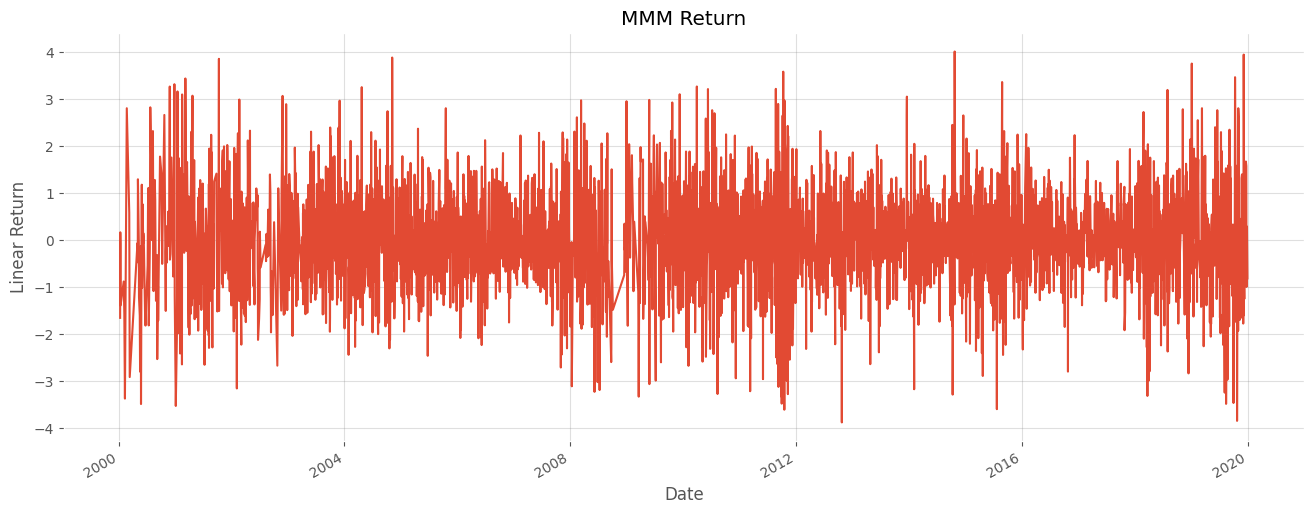

In [49]:
"""From here, we want to check if the Linear Return is close to 0 hence, we randomly select 1 stock (MMM) to check.
With this, data wangling ends here"""

plt.figure(figsize = [16, 6]
          )

plt.title("MMM Return")

plt.ylabel("Linear Return")

(
    scaled_all_stocks_adj_close
    ["MMM"]
    .plot()
) 

In [50]:
"""Over here, we are splitting the data set into training and testing. 
The purpose is for,
1. Model Evaluation
2. Overfitting Detection
3. Parameter Tuning
4. Model Selection
5. Realistic Assessment
6. Data Integrity"""

prop =\
    int(len(scaled_all_stocks_adj_close) * 0.80)

X_Train = scaled_all_stocks_adj_close[    : prop] # First 80% of the data for PCA
X_Test  = scaled_all_stocks_adj_close[prop:     ] # Remaining 20% of the data for backtesting

X_Train_Raw = Daily_Linear_Return[    :prop]
X_Test_Raw  = Daily_Linear_Return[prop:    ]

In [51]:
stock_tickers =\
(
 scaled_all_stocks_adj_close
 .columns
 .values
)

stock_tickers

array(['ABT', 'ADM', 'AEP', 'BA', 'BMY', 'CAT', 'CL', 'CMS', 'COP', 'CPB',
       'CSX', 'CVS', 'CVX', 'DE', 'DTE', 'ED', 'EIX', 'ETN', 'ETR', 'EXC',
       'F', 'GD', 'GE', 'GIS', 'HAL', 'HIG', 'IBM', 'KO', 'MMM', 'MO'],
      dtype=object)

In [52]:
"""PCA advantges:
1. Dimensionality Reduction
2. Noise Reduction
3. Visualization
4. Feature Engineering
5. Data Compression"""


from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
pca = PCA()

PrincipalComponent = pca.fit(X_Train)

In [53]:
"""the pca components means each row contain a principal component,
each column is the origin feature of the data and the data is sorted by explained variance,
the pca.components_[0] means to find the principal component with biggest explained variance"""

pca.components_[0]

array([-0.157, -0.169, -0.201, -0.182, -0.154, -0.211, -0.165, -0.186,
       -0.179, -0.158, -0.198, -0.153, -0.208, -0.188, -0.201, -0.181,
       -0.164, -0.225, -0.187, -0.18 , -0.165, -0.192, -0.198, -0.153,
       -0.163, -0.199, -0.182, -0.179, -0.218, -0.148])

In [54]:
"""The explained variance of PCA is the correlation of the original data,
which means the higher explained variance,
the higher correlation the more infromation is contained,
the eignvalue is number of the explained variance of PCA, 
usually we can reduce the lower eignvalue to maintain information with reduced dimension"""

'The explained variance of PCA is the correlation of the original data,\nwhich means the higher explained variance,\nthe higher correlation the more infromation is contained,\nthe eignvalue is number of the explained variance of PCA, \nusually we can reduce the lower eignvalue to maintain information with reduced dimension'

In [55]:
"""Let's retain 10 eigenvalues or principal components"""

NumEigenValues = 10

<Axes: title={'center': 'Cumulative Explained Variance by Each PC'}>

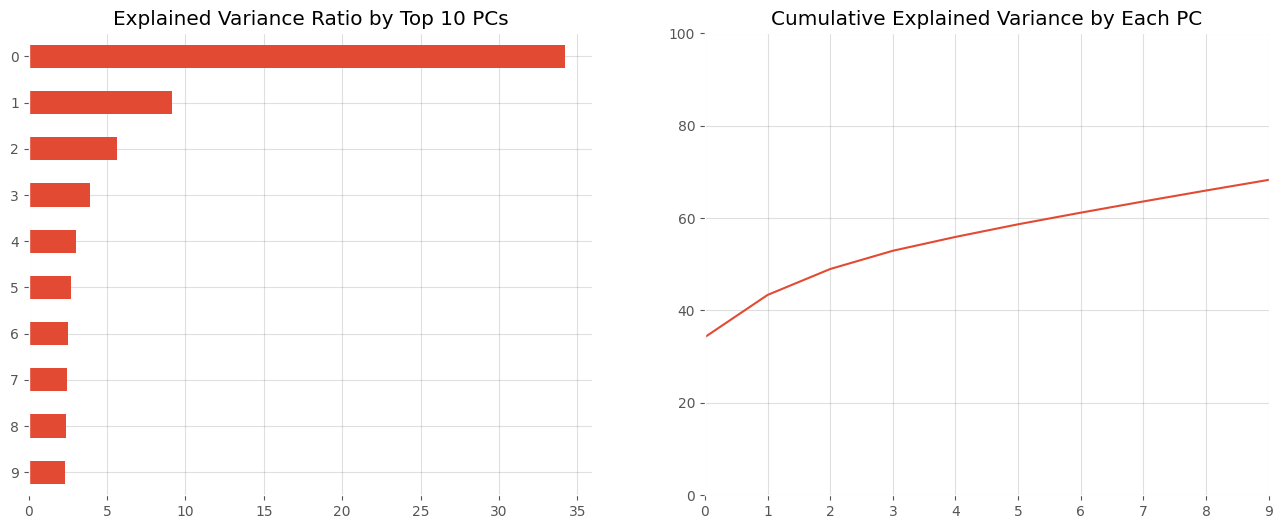

In [56]:
"""For Explained Variance, we are trying to see how much of the total variance in the original data 
is explained by each of the top principal components (PCs).

Hence, it calculated the cumulative explained variance ratio for those top components. 
This ratio provides insight into how much information is retained 
in the reduced-dimensional representation of the data."""

fig, axes =\
(
    plt
    .subplots(ncols = 2,
              figsize = [16, 6]
             )
)

# Plot on the left panel

Series1 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .sort_values()
    * 100
)

# Plot on the right panel

Series2 =\
(
    pd
    .Series(pca
            .explained_variance_ratio_[ :NumEigenValues]
           )
    .cumsum()
    * 100
)

(
    Series1
    .plot
    .barh(ylim = (0, 9),
          title = "Explained Variance Ratio by Top 10 PCs",
          ax = axes[0]
         )
)

(
    Series2
    .plot(ylim = (0, 100),
          xlim = (0, 9),
          title = "Cumulative Explained Variance by Each PC",
          ax = axes[1]
         )
)



In [57]:
"""To see the cumulative explained variance"""

(
    pd
    .Series(np
           .cumsum(pca
                   .explained_variance_ratio_)
           )
    .to_frame("Explained Variance")
    .head(NumEigenValues)
    .style
    .format("{:,.2%}".format)
)

,Explained Variance
0,34.24%
1,43.36%
2,48.98%
3,52.93%
4,55.92%
5,58.66%
6,61.17%
7,63.60%
8,65.96%
9,68.27%


In [58]:
"""Here, we have the weights of the factors on each principal component for our 30 stocks"""

pca.components_

array([[-1.567e-01, -1.687e-01, -2.006e-01, -1.823e-01, -1.536e-01,
        -2.110e-01, -1.650e-01, -1.855e-01, -1.786e-01, -1.583e-01,
        -1.978e-01, -1.527e-01, -2.076e-01, -1.884e-01, -2.010e-01,
        -1.815e-01, -1.643e-01, -2.249e-01, -1.875e-01, -1.801e-01,
        -1.647e-01, -1.917e-01, -1.975e-01, -1.534e-01, -1.627e-01,
        -1.988e-01, -1.817e-01, -1.792e-01, -2.183e-01, -1.485e-01],
       [-2.148e-02, -6.877e-02,  3.265e-01, -1.373e-01, -5.150e-02,
        -1.911e-01, -4.581e-03,  2.592e-01, -1.012e-01,  4.716e-02,
        -1.492e-01, -5.599e-02, -9.240e-02, -1.810e-01,  3.136e-01,
         3.471e-01,  2.614e-01, -2.045e-01,  3.368e-01,  3.143e-01,
        -1.797e-01, -1.172e-01, -1.372e-01,  4.411e-02, -1.206e-01,
        -1.405e-01, -1.246e-01,  1.698e-02, -1.522e-01,  5.004e-02],
       [ 2.827e-01,  3.649e-02, -6.100e-02,  7.096e-02,  2.243e-01,
        -1.788e-01,  3.039e-01, -8.519e-02, -3.253e-01,  2.670e-01,
        -8.487e-02,  1.774e-01, -2.821e-01, -1

In [59]:
"""Over here, we have a for loop that loops through each principal component (eigenvector) in pca.components_.
It calculates the normalized weights by dividing each component by the sum of its values. 
To ensure each component sum up to 1.
Next, normalized weights are added as a new column to the weights DataFrame.
Lastly, the DataFrame is transposed

Therefore, it will return a matrix that have each principal component's normalized weights, 
sorted by the order of explained variance"""

def PCWeights():

    weights = pd.DataFrame()

    for i in range(len(pca.components_)
                  ):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i]
                                                                  )

    weights = weights.values.T
    return weights

In [60]:
weights = PCWeights()

In [61]:
"""Here comes the more interesting part!

We will construct 5 portfolios with the weights of each stock as each of the first five PC.

Next, we ensure the portfolio sums up to 1.

Rename the index for better readability.

Lastly, sqrt it to return us the std of returns for each eigenportfolio"""

NumComponents = 5

topPortfolios =\
(
    pd
    .DataFrame(pca.components_[ : NumComponents],
               columns = all_stocks_adj_close.columns)
)
    
eigen_portfolios =\
(
    topPortfolios
    .div(topPortfolios.sum(1),
         axis = 0)
)
    
eigen_portfolios.index = [f"Portfolio {i}" for i in range(NumComponents)
                         ]
    
np.sqrt(pca.explained_variance_)

array([3.278, 1.692, 1.327, 1.113, 0.97 , 0.926, 0.888, 0.873, 0.861,
       0.851, 0.834, 0.825, 0.811, 0.796, 0.786, 0.777, 0.771, 0.754,
       0.729, 0.713, 0.694, 0.689, 0.68 , 0.66 , 0.633, 0.61 , 0.604,
       0.58 , 0.549, 0.486])

In [62]:
"""Now, let's generate our 5 portfolios"""

eigen_portfolios

,ABT,ADM,AEP,BA,BMY,CAT,CL,CMS,COP,CPB,...,F,GD,GE,GIS,HAL,HIG,IBM,KO,MMM,MO
Portfolio 0,0.028797,0.030995,0.036854,0.033502,0.028220,0.038776,0.030313,0.034090,0.032824,0.029077,...,0.030264,0.035231,0.036295,0.028191,0.029895,0.036519,0.033386,0.032920,0.040113,0.027280
Portfolio 1,-0.249328,-0.798063,3.789331,-1.593430,-0.597660,-2.218306,-0.053170,3.007977,-1.174505,0.547261,...,-2.085783,-1.360063,-1.592448,0.511908,-1.399414,-1.630464,-1.446255,0.197027,-1.765855,0.580792
Portfolio 2,0.943040,0.121726,-0.203506,0.236718,0.748374,-0.596408,1.013654,-0.284187,-1.085213,0.890826,...,-0.031328,0.154192,0.181707,0.888358,-1.263859,0.064182,0.191312,0.905599,0.155687,0.811056
Portfolio 3,0.302129,0.956580,-0.433782,-0.839555,0.204273,-0.521370,0.782215,-0.490958,1.723418,0.600912,...,-1.302789,-0.725556,-0.561663,0.938857,1.451549,-0.954482,-0.295040,0.956584,-0.296652,0.865260
Portfolio 4,4.411808,-2.057278,0.324243,1.162202,4.804787,-2.039415,-2.141875,0.565261,1.265401,-1.386815,...,-0.290024,1.392048,0.132595,-1.832662,1.098817,0.201023,0.537478,-2.206001,-0.372991,-0.627209


In [63]:
"""To check if the first portfolio weight sum to 1"""

eigen_portfolios.iloc[0].sum()

1.0

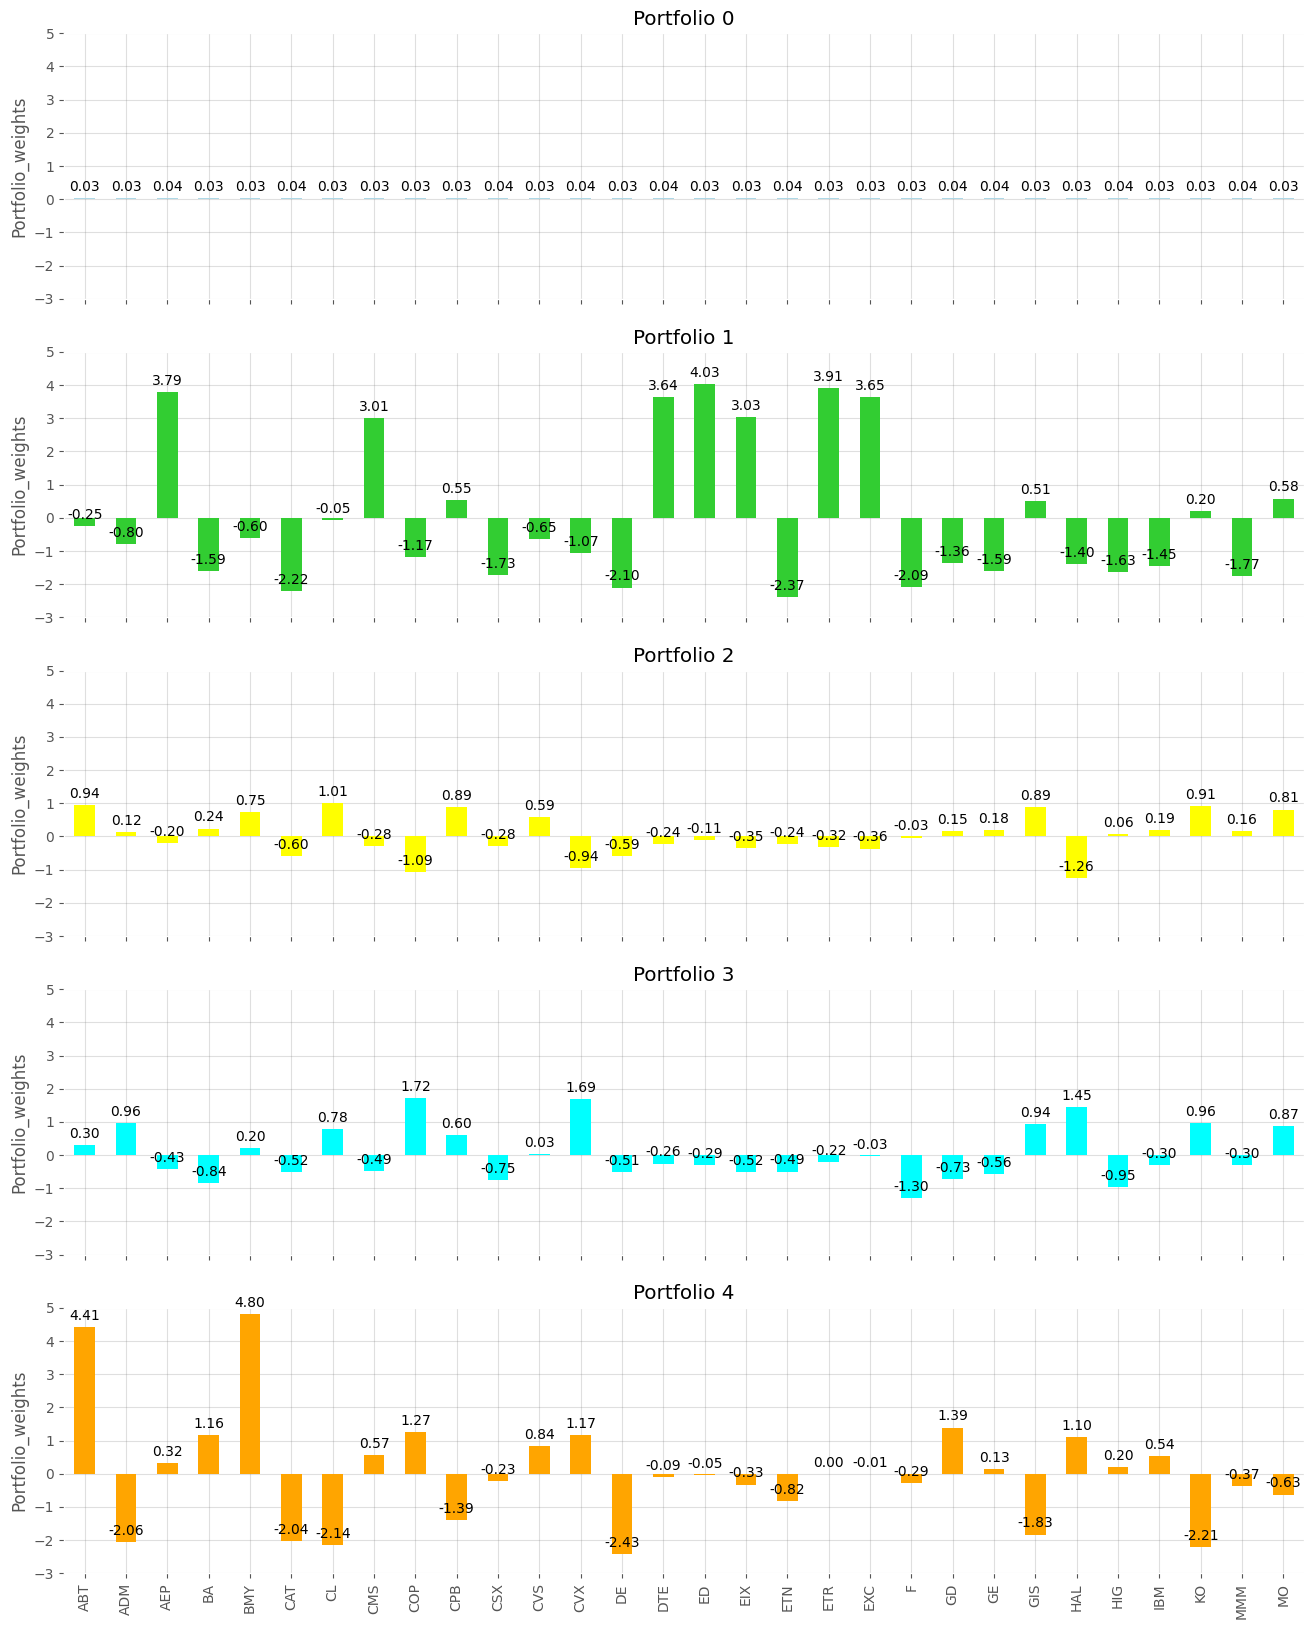

In [64]:
"""Let's visualize the contribution of different stocks in each eigenvector."""

(eigen_portfolios
    .T
    .plot
    .bar(subplots=True,
         layout=(int(NumComponents), 1),
         legend=False,
         sharey=True,
         figsize=[16, 20],
         ylim=[-3, 5],
         color=['lightblue', 'limegreen', 'yellow', 'cyan', 'orange']  # Add your custom bar colors
        )
)

# Adding y-axis labels to each subplot
for i, ax in enumerate(plt.gcf().axes):
    ax.set_ylabel('Portfolio_weights')
    
# Add y-axis values on top of each bar
for ax in plt.gcf().axes:
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  # Format the value as desired
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset for the y-value position
                    textcoords='offset points',
                    ha='center',
                    va='bottom'
                   )

# Show the plot
plt.show()

<Axes: >

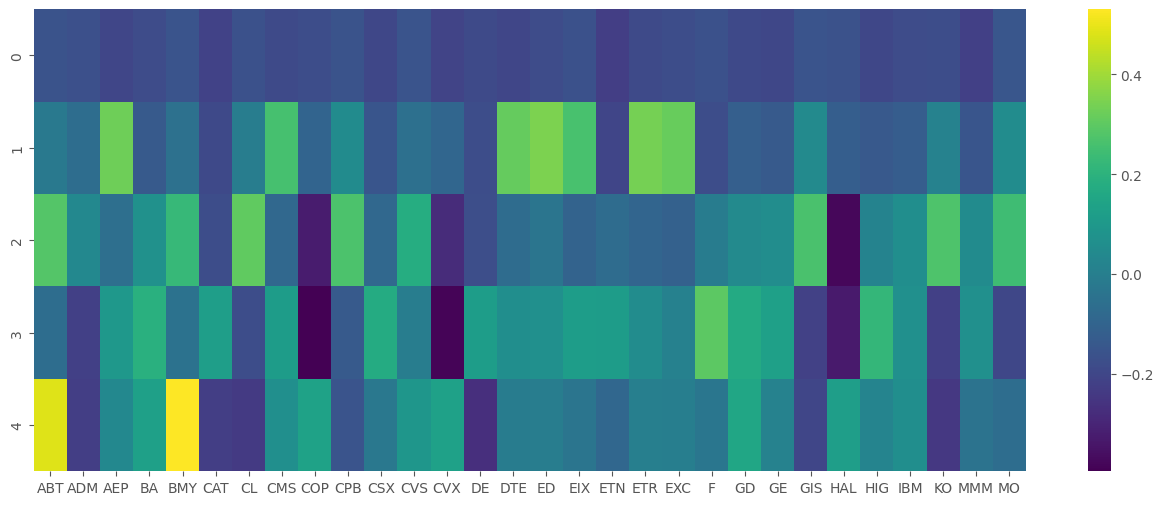

In [65]:
plt.figure(figsize = [16, 6]
          )

sns.heatmap(topPortfolios,
            cmap = "viridis")

In [66]:
"""Let's use Sharpe Ratio to compute our returns!"""

def calculate_sharpe_ratio(ts_returns, periods_per_year = 252):

    n_years = ts_returns.shape[0] / periods_per_year

    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)
                                ) - 1

    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)

    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

In [67]:
"""Over here, we are trying to extract the top 10 eigenportfolios based on Sharpe Ratio.

Initialize arrays for annualized return, volatility, and Sharpe ratio of each eigenportfolio

Loop through each eigenportfolio

Create a DataFrame for the eigenportfolio weights

Calculate returns for the eigenportfolio
np.dot function in Python is used for matrix multiplication or dot products of arrays

Calculate annualized return, volatility, and Sharpe ratio for the eigenportfolio

Store the metrics in their respective arrays

Let's find a portfolio with the HIGHEST Sharpe Ratio"""

def recommend_optimal_portfolio():
    
    n_portfolios = len(pca.components_)
    
    annualized_ret = np.array([0.] * n_portfolios)

    sharpe_metric = np.array([0.] * n_portfolios)

    annualized_vol = np.array([0.] * n_portfolios)
    
    highest_sharpe = 0
    
    stock_tickers =\
    (scaled_all_stocks_adj_close
     .columns 
     .values)

    n_tickers = len(stock_tickers)
    
    PCs = pca.components_

    for i in range(n_portfolios):
        
        pc_w = PCs[i] / sum(PCs[i])
        
        eigen_prtfi =\
            (
                pd
                .DataFrame(data = {"weights": pc_w.squeeze() * 100},
                           index = stock_tickers)
            )
        
        eigen_prtfi.sort_values(by = ["weights"],
                                ascending = False,
                                inplace = True)

        eigen_prti_returns =\
            (
                np
                .dot(X_Train_Raw.loc[ : , eigen_prtfi.index],
                     pc_w)
            )

        eigen_prti_returns =\
            (
                pd
                .Series(eigen_prti_returns.squeeze(),
                        index = X_Train_Raw.index)
            )
        
        er, vol, sharpe = calculate_sharpe_ratio(eigen_prti_returns)
        
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric = np.nan_to_num(sharpe_metric)

    highest_sharpe = np.argmax(sharpe_metric)
    

    
    results =\
        (
            pd
            .DataFrame(data = {"Return": annualized_ret,
                               "Vol": annualized_vol,
                               "Sharpe": sharpe_metric}
                      )
        )
    results.replace([np.inf, -np.inf], np.nan, inplace=True)
    results.dropna(inplace = True)

    results.sort_values(by = ["Sharpe"],
                        ascending = False,
                        inplace = True)

    print(results.head(10)
         )

In [68]:
"""The optimal portfolio has the following results
Return: 17.48%
Volatility: 12.33%
Sharpe Ratio: 1.42"""

recommend_optimal_portfolio()

      Return        Vol    Sharpe
0   0.174755   0.123382  1.416381
8   0.343488   0.768801  0.446785
5  -1.000000  16.465545 -0.060733
15 -0.098768   1.375811 -0.071789
27 -1.000000   9.641191 -0.103722
9  -1.000000   7.450543 -0.134218
22 -0.237959   1.639875 -0.145108
18 -0.209403   1.059190 -0.197702
1  -0.452808   2.091372 -0.216513
16 -0.408345   1.478339 -0.276219


In [69]:
"""Finally, we backtest our baby."""

def backtest_PCA_porfolios(eigen):

    eigen_prtfi =\
        (
            pd
            .DataFrame(data = {"weights": eigen.squeeze()
                              },
                       index = stock_tickers)
        )

    eigen_prtfi.sort_values(by = ["weights"],
                            ascending = False,
                            inplace = True)

    eigen_prtfi_returns =\
    (
        np
        .dot(X_Test_Raw
             .loc[ : , eigen_prtfi.index],
             eigen)
    )

    eigen_portfolio_returns =\
    (
        pd
        .Series(eigen_prtfi_returns.squeeze(),
                index = X_Test_Raw.index)
    )

    returns, vol, sharpe = calculate_sharpe_ratio(eigen_portfolio_returns)

    print("Our PCA-based Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f"  %
          (returns * 100, vol * 100, sharpe)
         )

    equal_weight_return =\
    (
        X_Test_Raw * (1 / len(pca.components_)
                     )
    ).sum(axis = 1)

    df_plot =\
        (
            pd
            .DataFrame({"ML Portfolio Return": eigen_portfolio_returns,
                        "Equal Weight Index": equal_weight_return},
                      index = X_Test.index
                      )
        )

    (
        np
        .cumprod(df_plot + 1)
        .plot(title = "Returns of the equal weighted index vs. Eigen-Portfolio",
              figsize = [16, 8]
             )
    )

    plt.show()

### <font color = red> Answer 7 is presented in the cell below: </font>

Our PCA-based Portfolio:
Return = 109.37%
Volatility = 76.72%
Sharpe = 1.43


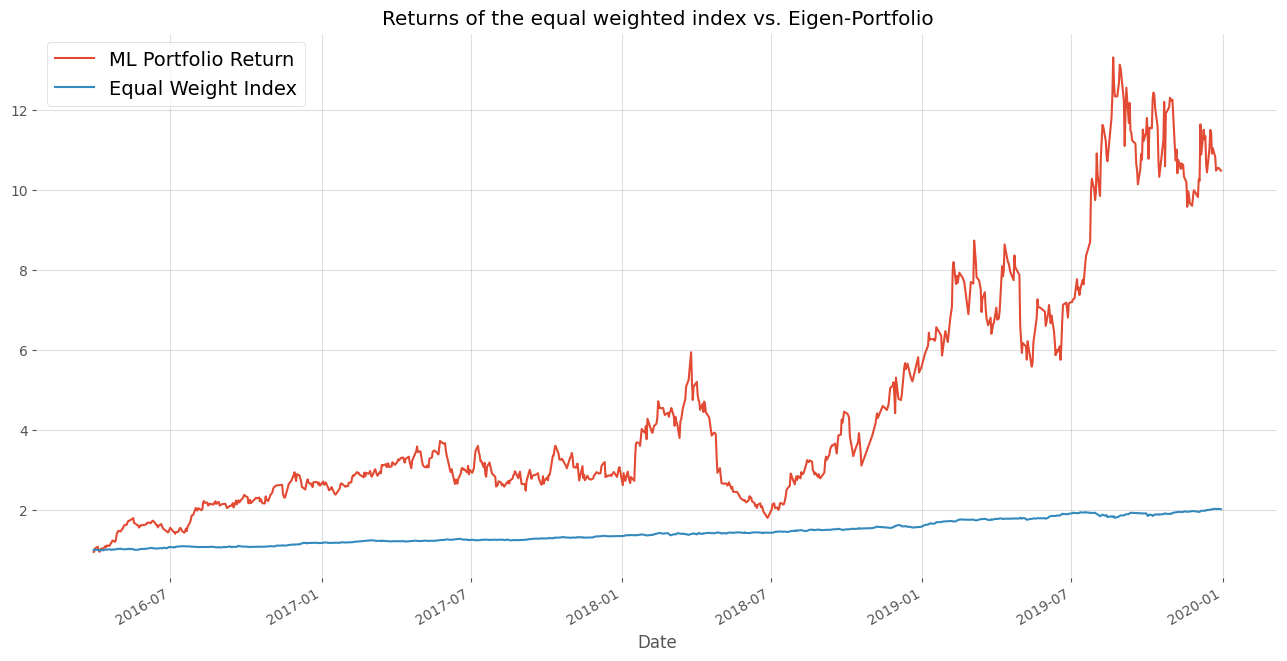

In [70]:
backtest_PCA_porfolios(eigen = weights[8]
                      )

> 💯 “Thank you for putting your efforts into the individual assessment questions” 😊